In [42]:
!pip install requests
import urllib.request

!pip install tsplib95
import tsplib95

^C
ERROR: Operation cancelled by user


In [ ]:
import random  # Libreria para generar numeros y listas aleatorias
import copy  # Permite hacer copias de objetos en python: listas, diccionarios,...

In [43]:
# Librerias y carga del problema

# http://elib.zib.de/pub/mp-testdata/tsp/tsplib/
# Documentacion :
# https://wwwproxy.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/tsp95.pdf
# https://tsplib95.readthedocs.io/usage.html
# https://tsplib95.readthedocs.io/modules.html#module-tsplib95.models

# Descargamos el fichero de datos(Matriz de distancias)
file = "swiss42.tsp"
urllib.request.urlretrieve(
    "http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/swiss42.tsp.gz",
    file + ".gz",
)
# !gzip -d swiss42.tsp.gz     #Descomprimir el fichero de datos

# Objeto de tsplib95 para nuestro problema problema
problem = tsplib95.load_problem(file)

# Nodos
Nodos = list(problem.get_nodes())

# Aristas
Aristas = list(problem.get_edges())

# Coordenadas(si estan disponibles en el ficher)
problem.get_display(1)

# Distancia
problem.get_weight(1, 2)

# Matriz de distancias
[
    [problem.get_weight(i, j) for i in list(problem.get_nodes())]
    for j in list(problem.get_nodes())
]

/var/folders/mw/8zsr5x410_d4hjk34txfhft40000gq/T/ipykernel_74267/4064541894.py:18: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem(file)


[[0,
  15,
  30,
  23,
  32,
  55,
  33,
  37,
  92,
  114,
  92,
  110,
  96,
  90,
  74,
  76,
  82,
  67,
  72,
  78,
  82,
  159,
  122,
  131,
  206,
  112,
  57,
  28,
  43,
  70,
  65,
  66,
  37,
  103,
  84,
  125,
  129,
  72,
  126,
  141,
  183,
  124],
 [15,
  0,
  34,
  23,
  27,
  40,
  19,
  32,
  93,
  117,
  88,
  100,
  87,
  75,
  63,
  67,
  71,
  69,
  62,
  63,
  96,
  164,
  132,
  131,
  212,
  106,
  44,
  33,
  51,
  77,
  75,
  72,
  52,
  118,
  99,
  132,
  132,
  67,
  139,
  148,
  186,
  122],
 [30,
  34,
  0,
  11,
  18,
  57,
  36,
  65,
  62,
  84,
  64,
  89,
  76,
  93,
  95,
  100,
  104,
  98,
  57,
  88,
  99,
  130,
  100,
  101,
  179,
  86,
  51,
  4,
  18,
  43,
  45,
  95,
  45,
  115,
  93,
  152,
  159,
  100,
  112,
  114,
  153,
  94],
 [23,
  23,
  11,
  0,
  11,
  48,
  26,
  54,
  70,
  94,
  69,
  89,
  75,
  84,
  84,
  89,
  92,
  89,
  54,
  78,
  99,
  141,
  111,
  109,
  190,
  89,
  44,
  11,
  29,
  54,
  56,
  89,
  47,
  1

In [44]:
# Funciones de la Actividad Guiada 3
# Se genera una solucion aleatoria con comienzo en en el nodo 0
def crear_solucion(Nodos):
    solucion = [Nodos[0]]
    for n in Nodos[1:]:
        solucion = solucion + [random.choice(list(set(Nodos) - set(solucion)))]
    return solucion


# Devuelve la distancia entre dos nodos
def distancia(a, b, problem):
    return problem.get_weight(a, b)


# Devuelve la distancia total de una trayectoria/solucion
def distancia_total(solucion, problem):
    distancia_total = 0
    for i in range(len(solucion) - 1):
        distancia_total += distancia(solucion[i], solucion[i + 1], problem)
    return distancia_total + distancia(
        solucion[len(solucion) - 1], solucion[0], problem
    )

In [45]:
distancia_total(
    [
        0,
        32,
        34,
        33,
        20,
        35,
        36,
        31,
        17,
        7,
        1,
        6,
        4,
        3,
        27,
        2,
        28,
        29,
        30,
        38,
        22,
        39,
        21,
        24,
        40,
        23,
        41,
        9,
        8,
        10,
        25,
        11,
        12,
        18,
        26,
        5,
        13,
        19,
        14,
        16,
        15,
        37,
    ],
    problem,
)

1326

In [121]:
# Genera una poblacion inicial de soluciones de tamaño N
def generar_poblacion(Nodos, N):
    return [crear_solucion(Nodos) for _ in range(N)]


# Evalua la población y devuelve el mejor individuo
def Evaluar_Poblacion(poblacion, problem):
    mejor_solucion = []
    mejor_distancia = 10e100
    for p in poblacion:
        # print("solucion:", p)
        distancia_referencia = distancia_total(p, problem)
        if distancia_referencia < mejor_distancia:
            mejor_solucion = p
            mejor_distancia = distancia_referencia
    return mejor_solucion, mejor_distancia


# Funcion de cruce. Recibe una poblacion(lista de soluciones) y devuelve la población ampliada con los hijos.
# Todos los individuos de la población son selecionados para el cruce(si la población es par)
# Podría aplicarse un proceso previo de selección para elegir los individuos que se desea cruzar.
def Cruzar(poblacion, mutacion, problem):
    # Definimos en una variable la copia de la población para ir eliminando los padres seleccionados
    poblacion_copia = copy.deepcopy(poblacion)

    # Definimos en una variable la copia de la población para ir añadiendo los hijos creados
    poblacion_final = copy.deepcopy(poblacion)

    while len(poblacion_copia) > 1:  # Iteramos mientras haya padres disponibles
        # Seleccionamos dos padres
        padre1, padre2 = random.sample(poblacion_copia, 2)
        poblacion_copia.remove(padre1)
        poblacion_copia.remove(padre2)
        poblacion_final.extend(Descendencia([padre1, padre2], problem, mutacion))
    return poblacion_final


# Funcion para generar hijos a partir de 2 padres:
# Se elige el metodo de 1-punto de corte pero es posible usar otros n-puntos, uniforme, dependiendo del problema
def Descendencia(padres, problem, mutacion):
    # Se elige un punto de corte aleatorio:
    pc = random.choice(range(len(padres[0])))
    hijo1 = Factibilizar(padres[0][:pc] + padres[1][pc:], problem)
    hijo2 = Factibilizar(padres[1][:pc] + padres[0][pc:], problem)
    return [hijo1, hijo2, Mutar(hijo1, mutacion), Mutar(hijo2, mutacion)]


# Para el operador de cruce 1-punto los hijos generados no son soluciones(algunos nodos se repiten y otros no están)
def Factibilizar(solucion, problem):
    Nodos = list(problem.get_nodes())
    nodos_desaparecidos = list(set(Nodos) - set(solucion))
    # Recorremos todos los nodos, cuando haya uno que ya esté en la lista los cambiamos por uno de la lista de nodos_desaparecidos
    for i in range(len(solucion)):
        if solucion[i] in solucion[:i]:
            # print("\tSe repite el",solucion[i] )
            # print("\tSe cambia en la posicion ",i , " " ,solucion[i] , " por ", nodos_desaparecidos[0] )
            solucion[i] = nodos_desaparecidos.pop(
                0
            )  # Cambiamos el nodo y a la vez eliminamos el nodo usado de nodos_desaparecidos
    return solucion


# Funcion de mutación. Se eligen dos nodos y se intercambia. Se podrian añadir otros operaradores
# Se hace mutaciones mutacion% de las veces
def Mutar(solucion: list, mutacion):
    if random.random() < mutacion:
        sel1, sel2 = random.sample(range(len(solucion)), 2)
        aux = solucion.copy()
        aux[sel1], aux[sel2] = aux[sel2], aux[sel1]
        return aux

    return solucion


# Funcion de seleccion de la población. Recibe como parametro una poblacion y
# devuelve una poblacion a la que se ha eliminado individuos poco aptos(fitness alto) y para mantener una poblacion estable de N individuos
# Se tiene en cuenta el porcentaje elitismo pasado como parametro
# Para los individuos que no son de la elite podríamos usar una selección de ruleta(proporcional a su fitness)
def Seleccionar(problem, poblacion, N, elitismo):
    # Se ordena la población según el fitness(tamaño del recorrido) en una lista de elementos [distancia, solucion]
    poblacion_ordenada = sorted(
        [[distancia_total(solucion, problem), solucion] for solucion in poblacion],
        key=lambda x: x[0],
    )

    # Devolvemos elitismo% y el resto se eligen aleatoriamente
    return [x[1] for x in poblacion_ordenada][: int(N * elitismo)] + random.sample(
        [x[1] for x in poblacion_ordenada][int(N * elitismo) :], int(N * (1 - elitismo))
    )

In [120]:
# Funcion principal del algoritmo genetico
#######################################################3
def algoritmo_genetico(
    problem=problem, N=100, mutacion=0.15, elitismo=0.1, generaciones=100
):
    # problem = datos del problema
    # N = Tamaño de la población
    # mutacion = probabilidad de una mutación
    # elitismo = porcion de la mejor poblacion a mantener
    # generaciones = nº de generaciones a generar para finalizar

    # Genera la poblacion inicial
    Nodos = list(problem.get_nodes())
    poblacion = generar_poblacion(Nodos, N)

    # Inicializamos valores para la mejor solucion
    (mejor_solucion, mejor_distancia) = Evaluar_Poblacion(poblacion, problem)

    # Inciamos el cliclo de generaciones
    for n in range(generaciones):
        # Cruce de la poblacion(incluye mutación)
        poblacion = Cruzar(poblacion, mutacion, problem)

        # Seleccionamos la población
        poblacion = Seleccionar(problem, poblacion, N, elitismo)

        # Evaluamos la nueva población
        (mejor_solucion, mejor_distancia) = Evaluar_Poblacion(poblacion, problem)

        print(
            "Generacion #",
            n + 1,
            "\nLa mejor solución es:",
            mejor_solucion,
            "\ncon distancia ",
            mejor_distancia,
            "\n",
        )

    return mejor_solucion


# 1º intento  :2113
# sol = algoritmo_genetico(problem=problem,N=100,mutacion=.15,elitismo=.1,generaciones=200)

# 2º intento. Aumentamos la poblacion:1654
# sol = algoritmo_genetico(problem=problem,N=500,mutacion=.15,elitismo=.1,generaciones=200)

# 3º intento. Aumentamos las generaciones:2055
# sol = algoritmo_genetico(problem=problem,N=500,mutacion=.15,elitismo=.1,generaciones=250)

# 4º intento. Aumentamos el elitismo: 1728
# sol = algoritmo_genetico(problem=problem,N=500,mutacion=.15,elitismo=.40,generaciones=250)

# 5º intento. Aumentamos la mutacion : 1629 [0, 29, 9, 21, 40, 24, 39, 22, 38, 30, 28, 4, 18, 26, 5, 6, 32, 34, 33, 20, 35, 36, 31, 17, 37, 7, 8, 23, 41, 10, 25, 11, 12, 13, 19, 14, 16, 15, 1, 3, 2, 27]
sol = algoritmo_genetico(
    problem=problem, N=300, mutacion=0.15, elitismo=0.3, generaciones=250
)

Generacion # 1 
La mejor solución es: [0, 32, 16, 23, 1, 9, 38, 4, 27, 29, 12, 39, 24, 40, 25, 13, 14, 36, 7, 5, 8, 21, 28, 33, 19, 37, 18, 6, 41, 10, 26, 11, 17, 15, 20, 35, 2, 22, 30, 31, 34, 3] 
con distancia  3897 

Generacion # 2 
La mejor solución es: [0, 5, 7, 20, 22, 23, 8, 25, 38, 28, 4, 3, 13, 10, 19, 2, 9, 18, 12, 33, 1, 26, 35, 11, 29, 27, 24, 41, 40, 30, 32, 34, 21, 39, 36, 37, 6, 15, 14, 16, 17, 31] 
con distancia  3750 

Generacion # 3 
La mejor solución es: [0, 5, 7, 20, 22, 23, 8, 25, 38, 28, 4, 3, 13, 10, 19, 2, 9, 18, 12, 33, 1, 26, 35, 11, 29, 27, 24, 41, 40, 30, 32, 34, 21, 39, 36, 37, 6, 15, 14, 16, 17, 31] 
con distancia  3750 

Generacion # 4 
La mejor solución es: [0, 5, 7, 20, 22, 23, 8, 25, 38, 28, 4, 3, 13, 10, 19, 2, 9, 18, 12, 33, 1, 26, 35, 11, 29, 27, 24, 41, 40, 30, 32, 34, 21, 39, 36, 37, 6, 15, 14, 16, 17, 31] 
con distancia  3750 

Generacion # 5 
La mejor solución es: [0, 3, 30, 12, 10, 40, 31, 5, 19, 4, 32, 34, 9, 22, 38, 13, 14, 26, 33, 20, 17, 7,

KeyboardInterrupt: 

In [213]:
def SinglePointCross(parents):
    p1, p2 = parents

    # pick a random point to split
    i = random.choice(range(1, len(p1) - 1))
    print("Single point Crossover:", i)

    c1 = p1[:i] + p2[i:]
    c2 = p2[:i] + p1[i:]
    return [c1, c2]


def TwoPointCross(parents):
    p1, p2 = parents

    # pick two random points to split
    i1, i2 = sorted(random.sample(range(1, len(p1) - 1), 2))
    print("Two point Crossover:", i1, i2)

    c1 = p1[:i1] + p2[i1:i2] + p1[i2:]

    c2 = p2[:i1] + p1[i1:i2] + p2[i2:]

    return [c1, c2]


def MultiPointCross(parents):
    p1, p2 = parents

    # pick two random points to split
    points = sorted(
        random.sample(range(1, len(p1) - 1), random.randint(2, len(p1) - 2))
    )
    print("Multi point Crossover:", *points)

    c1 = []
    c2 = []

    start_idx = 0

    for split_idx in points:
        c1 += p1[start_idx:split_idx]
        c2 += p2[start_idx:split_idx]

        start_idx = split_idx
        p1, p2 = p2, p1

    c1 += p1[start_idx:]
    c2 += p2[start_idx:]

    return [c1, c2]


def UniformCross(parents):
    c1 = []
    c2 = []

    selection = []

    for i in range(len(parents[0])):
        should_swap = random.random() > 0.5
        selection.append("p1" if should_swap else "p2")

        p1, p2 = parents if should_swap else parents[::-1]
        c1.append(p1[i])
        c2.append(p2[i])

    print("Uniform Crossover:", *selection)

    return [c1, c2]

Single point Crossover: 1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 8, 7, 6, 5, 4, 3, 2, 1, 0], [0, 8, 7, 6, 5, 4, 3, 2, 1, 0], [9, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
Two point Crossover: 3 6
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 8, 7, 6, 5, 4, 3, 2, 1, 0], [0, 1, 2, 6, 5, 4, 6, 7, 8, 9], [9, 8, 7, 3, 4, 5, 3, 2, 1, 0]]
Multi point Crossover: 2 5 7
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 8, 7, 6, 5, 4, 3, 2, 1, 0], [0, 1, 7, 6, 5, 5, 6, 2, 1, 0], [9, 8, 2, 3, 4, 4, 3, 7, 8, 9]]
Uniform Crossover: p1 p2 p1 p1 p1 p2 p1 p2 p1 p2
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 8, 7, 6, 5, 4, 3, 2, 1, 0], [0, 8, 2, 3, 4, 4, 6, 2, 8, 0], [9, 1, 7, 6, 5, 5, 3, 7, 1, 9]]


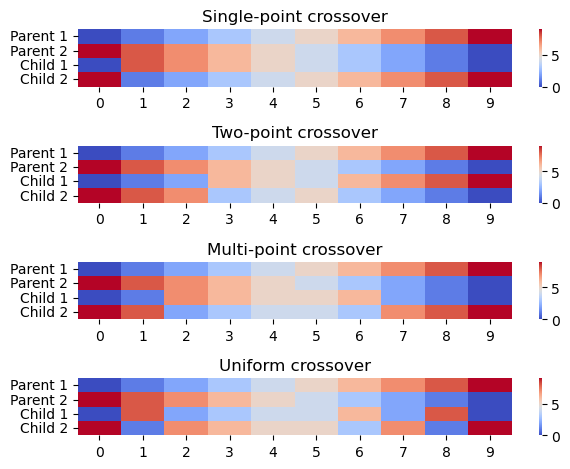

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

# amount of genes
n_genes = 10

p1, p2 = [list(range(n_genes)), list(range(n_genes))[::-1]]

runs = [
    {"name": "Single-point crossover", "fn": SinglePointCross},
    {"name": "Two-point crossover", "fn": TwoPointCross},
    {"name": "Multi-point crossover", "fn": MultiPointCross},
    {"name": "Uniform crossover", "fn": UniformCross},
]

xticklabels = range(1, n_genes + 1)
yticklabels = ["Parent 1", "Parent 2", "Child 1", "Child 2"]

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axs = plt.subplots(len(runs))


for i, run in enumerate(runs):
    c1, c2 = run["fn"]([p1, p2])

    data = [p1, p2, c1, c2]
    print(data)
    sns.heatmap(
        data,
        cmap="coolwarm",
        yticklabels=yticklabels,
        ax=axs[i],
    )
    axs[i].set_title(run["name"])

plt.tight_layout()
plt.show()